In [4]:
!pip install pandas matplotlib wandb numpy


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [5]:
save_plots_dir = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave'


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd

def wandb_viz_loss_with_std(exp_data,y_lim=None, figsize=(10, 6), make_legend=None, legend_font=14, starting_color=0, starting_style=0, color_by_loss_type = False, style_by_loss_type=True, plot_name=None, plot_std=True, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None, title=None, x_label=True, y_label=True):
    """
    exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...] containing labels and their experiment IDs
    """
    wandb.login()
    fig, ax1 = plt.subplots(figsize=figsize, dpi=300)
    ax2 = None
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    styles = ['-', '--', ':', '-.', '-', '--', ':', '-.']
    alphas = [1.0, 1.0]
    
    api = wandb.Api(timeout=29)
    all_losses = set()
    
    # Collect all loss types
    for _, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        for exp_n in exp_ids:
            run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
            if losses is None:
                all_losses.update([k for k in run.history().keys() if 'MSE' in k])
    
    losses = sorted(list(all_losses)) if losses is None else losses
    
    # Plot experiments
    for idx, (label, exp_ids) in enumerate(exp_data):
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids

        if not color_by_loss_type:
            base_color = colors[idx+starting_color]

        if not style_by_loss_type:
            style = styles[idx+starting_style]
        
        for idx, loss in enumerate(loss_types.keys()):
            if exclude is not None and any(loss in ex for ex in exclude):
                continue

            if color_by_loss_type:
                base_color = colors[idx+starting_color]

            if style_by_loss_type:
                style = styles[idx+starting_style]
                
            # style = styles[1] if 'val' in loss else styles[0]
            alpha = alphas[1] if 'val' in loss else alphas[0]
            
            # Collect data from all experiments
            all_data = []
            max_epoch = 0
            for exp_n in exp_ids:
                run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
                metrics = run.history()
                iteration = metrics['epoch']
                loss_data = metrics[loss]
                valid_data = [(i, l) for i, l in zip(iteration, loss_data) if not pd.isna(l)]
                if valid_data:
                    x, y = zip(*valid_data)
                    all_data.append((x, y))
                    max_epoch = max(max_epoch, max(x))
            
            if not all_data:
                continue
            

            # Interpolate to common x-axis
            common_x = np.linspace(0, max_epoch, 1000)
            interpolated_y = []
            
            for x, y in all_data:
                interpolated_y.append(np.interp(common_x, x, y))
            
            mean_y = np.mean(interpolated_y, axis=0)
            std_y = np.std(interpolated_y, axis=0)
            
            ax = ax2 if vars and loss in vars else ax1
            if y_lim is not None:
                ax.set_ylim(y_lim[0], y_lim[1])
            if ax2 is None and vars and loss in vars:
                ax2 = ax1.twinx()
                ax2.set_ylabel("Secondary Loss Metric", fontsize=20)
                if y_lim is not None:
                    ax2.set_ylim(y_lim[0], y_lim[1])

            if len(exp_data)>1:
                prefix = f'{label} - '
            else:
                prefix = ''
            
            ax.plot(common_x, mean_y, label=f"{prefix}{loss_types[loss] if loss_types else loss}", 
                    linestyle=style, color=base_color, alpha=alpha, linewidth=2)
            if plot_std:
                ax.fill_between(common_x, mean_y-std_y, mean_y+std_y, color=base_color, alpha=0.2)

    # Rest of the styling remains the same as in original function
    if x_label:
        ax1.set_xlabel("Epoch", fontsize=20)
    # if y_label:
    #     ax1.set_ylabel("Loss (log)", fontsize=20)
    if title:
        ax1.set_title(title, fontsize=20, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_yscale('log')
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    
    # if make_legend:
    #     if ax2:
    #         lines1, labels1 = ax1.get_legend_handles_labels()
    #         lines2, labels2 = ax2.get_legend_handles_labels()
    #         legend = ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=legend_font,
    #                             loc='upper right', bbox_to_anchor=(0.98, 0.98),
    #                             facecolor='white', edgecolor='black', framealpha=1.0)
    #     else:
    #         legend = ax1.legend(fontsize=legend_font, loc='upper right', bbox_to_anchor=(0.98, 0.98),
    #                             facecolor='white', edgecolor='black', framealpha=1.0)
        
    #     legend.get_frame().set_facecolor('white')
    #     legend.get_frame().set_edgecolor('black')
    #     legend.get_frame().set_alpha(1.0)
    #     #plt.tight_layout()
        
    std = 'with_std' if plot_std else 'without_std'

    ax1.tick_params(axis='both', labelsize=20)
    if ax2:
        ax2.tick_params(axis='both', labelsize=20)
    

    if plot_name is None:
        plot_name = exp_data[0][0]

    if save_dir:
        plt.savefig(f"{save_dir}/loss_curves_{std}_{plot_name}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()
    
    plt.close()

In [69]:
def wandb_final_loss_with_std(exp_data, train_loss=None, val_loss=None, test_loss=None, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    Prints a table of averaged final losses and their standard deviations for each loss type.
    
    Args:
        exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...]
        loss_types: dict mapping loss variable names (in wandb) to display names
    """
    wandb.login()
    api = wandb.Api(timeout=29)

    if loss_types is None:
        raise ValueError("loss_types must be provided and map wandb variable names to display labels.")

    table_rows = []

    for label, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        row = {'Label': label}

        # Find and record the best validation loss if specified
        if val_loss:
            best_epochs = []
            for exp_id in exp_ids:
                try:
                    run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                    history = run.history(keys=[val_loss, train_loss] if train_loss else [val_loss])
                    val_values = history[val_loss].dropna().values
                    if len(val_values) > 0:
                        best_epoch = val_values.argmin()
                    
                    if train_loss:
                        train_values = history[train_loss].dropna().values
                        if len(train_values) > best_epoch:
                            train_at_best = train_values[best_epoch]
                    best_epochs.append(train_at_best)
                    
                except Exception as e:
                    print(f"Skipping run {exp_id} for validation loss due to error: {e}")
                    
        for loss_var, display_name in loss_types.items():
            final_losses = []
            
            for exp_id in exp_ids:
                try:
                    run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                    history = run.history(keys=[loss_var])
                    values = history[loss_var].dropna().values
                    if len(values) > 0:
                        final_losses.append(values[-1])
                except Exception as e:
                    print(f"Skipping run {exp_id} due to error: {e}")
            


            if final_losses:
                mean_loss = np.mean(final_losses)
                std_loss = np.std(final_losses)
                row[f"{display_name}"] = f"{mean_loss:.6f} ± {std_loss:.6f}"
            else:
                row[f"{display_name}"] = "N/A"

            if final_losses and val_loss and test_loss:
                if loss_var == test_loss:
                    gen_error = np.abs(final_losses - train_at_best)
                    mean_loss = np.mean(gen_error)
                    std_loss = np.std(gen_error)
                    row[f"{display_name}-gen_error"] = f"{mean_loss:.6f} ± {std_loss:.6f}"
                
            if loss_var == val_loss:
                rel_train_val_diffs = []
                for exp_id in exp_ids:
                    try:
                        run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                        history = run.history(keys=[train_loss, val_loss])
                        train_values = history[train_loss].dropna().values
                        val_values = history[val_loss].dropna().values
                        min_len = min(len(train_values), len(val_values))
                        if min_len > 0:
                            rel_diff = np.mean(np.abs(val_values[:min_len] - train_values[:min_len])/train_values[:min_len])
                            rel_train_val_diffs.append(rel_diff)
                    except Exception as e:
                        print(f"Skipping run {exp_id} for train-val difference due to error: {e}")

                if rel_train_val_diffs:
                    mean_diff = np.mean(rel_train_val_diffs)
                    std_diff = np.std(rel_train_val_diffs)
                    row["train-val difference"] = f"{mean_diff:.6f} ± {std_diff:.6f}"
                else:
                    row["train-val difference"] = "N/A"
        table_rows.append(row)

    df = pd.DataFrame(table_rows)
    print(df.to_string(index=False))
    
    if save_dir:
        df.to_csv(f"{save_dir}/final_loss_summary_{exp_data[0][0]}.csv", index=False)

In [4]:
import pickle
import torch
from itertools import cycle
import os

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd
from matplotlib.ticker import MaxNLocator, LogLocator

def wandb_viz_loss_with_std(
    exp_data,
    y_lim=None,
    figsize=(10, 6),
    dpi=300,
    make_legend=False,
    legend_font=14,
    starting_color=0,
    starting_style=0,
    color_by_loss_type=False,
    style_by_loss_type=True,
    plot_name=None,
    plot_std=True,
    loss_types=None,
    save_dir=None,
    exclude=None,
    wandb_user='moritz-hauschulz',
    wandb_project='structure-preserving-operator-learning',
    losses=None,
    vars=None,
    title=None,
    x_label=True,
    y_label=True
):
    """
    exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...]
    loss_types: dict mapping loss key -> display name
    vars: list of loss keys to plot on secondary y-axis
    """
    # Set default tick label sizes
    # plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

    # Login and prepare figure
    wandb.login()
    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    ax2 = None

    # Color and style pools
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    styles = ['-', '--', ':', '-.'] * 2

    # Initialize API
    api = wandb.Api(timeout=60)

    # Determine loss metrics if not provided
    if losses is None:
        all_losses = set()
        for _, ids in exp_data:
            ids = [ids] if isinstance(ids, str) else ids
            for run_id in ids:
                history = api.run(f"{wandb_user}/{wandb_project}/{run_id}").history()
                all_losses.update([k for k in history.keys() if 'MSE' in k])
        losses = sorted(all_losses)

    # Main loop to plot each loss
    for exp_idx, (label, ids) in enumerate(exp_data):
        ids = [ids] if isinstance(ids, str) else ids
        base_color = colors[(exp_idx + starting_color) % len(colors)]
        base_style = styles[(exp_idx + starting_style) % len(styles)]

        for loss_idx, loss_key in enumerate(loss_types or losses):
            if exclude and any(exc in loss_key for exc in exclude):
                continue

            # Choose color/style
            color = colors[(loss_idx + starting_color) % len(colors)] if color_by_loss_type else base_color
            style = styles[(loss_idx + starting_style) % len(styles)] if style_by_loss_type else base_style
            alpha = 0.8 if 'val' in loss_key else 1.0

            # Gather run data
            all_runs, max_epoch = [], 0
            for run_id in ids:
                hist = api.run(f"{wandb_user}/{wandb_project}/{run_id}").history()
                epochs = hist['epoch']
                vals = hist.get(loss_key)
                pairs = [(e, v) for e, v in zip(epochs, vals) if not pd.isna(v)]
                if pairs:
                    x_vals, y_vals = zip(*pairs)
                    all_runs.append((x_vals, y_vals))
                    max_epoch = max(max_epoch, max(x_vals))

            if not all_runs:
                continue

            # Secondary axis if needed
            needs_secondary = vars and loss_key in vars
            if needs_secondary and ax2 is None:
                ax2 = ax1.twinx()
                ax2.set_ylabel('Secondary Loss Metric', fontsize=20)

            ax = ax2 if needs_secondary else ax1
            if y_lim:
                ax.set_ylim(*y_lim)

            # Plot single vs multiple runs
            if len(all_runs) == 1:
                x_plot, y_plot = all_runs[0]
                ax.plot(x_plot, y_plot,
                        label=f"{label} - {loss_types.get(loss_key, loss_key)}",
                        linestyle=style, color=color, alpha=alpha, linewidth=2)
            else:
                common_x = np.linspace(0, max_epoch, 1000)
                interp = [np.interp(common_x, x, y) for x, y in all_runs]
                mean_y = np.mean(interp, axis=0)
                std_y = np.std(interp, axis=0)
                ax.plot(common_x, mean_y,
                        label=f"{label} - {loss_types.get(loss_key, loss_key)}",
                        linestyle=style, color=color, alpha=alpha, linewidth=2)
                if plot_std:
                    ax.fill_between(common_x, mean_y - std_y, mean_y + std_y,
                                    color=color, alpha=0.2)

    # Final styling
    if x_label:
        ax1.set_xlabel('Epoch', fontsize=20)
    if y_label:
        ax1.set_ylabel('Loss (log)', fontsize=20)
    if title:
        ax1.set_title(title, fontsize=20, pad=15)

        # Log scale
    ax1.set_yscale('log')
    
    # Enable grid lines on both axes for major ticks
    # ax1.grid(which='major', axis='both', linestyle='--', alpha=0.7)
    
    # # Optionally enable minor grid lines for more finely spaced y-grids
    # # ax1.min/orticks_on()
    # ax1.grid(which='major', axis='y', linestyle='--', alpha=0.3)


    # Set tick locators for regular intervals
    # X-axis: integer epochs, max 10 ticks
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    # Y-axis: decades on log scale
    ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))

    # Secondary axis ticks
    if ax2 is not None:
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Apply tick style
    tick_kwargs = dict(which='major', labelsize=20, length=8, width=2)
    ax1.tick_params(axis='both', **tick_kwargs)
    if ax2 is not None:
        ax2.tick_params(axis='y', **tick_kwargs)

    
    ax1.grid(True, linestyle='--', alpha=0.7)


    # Adjust layout
    # fig.tight_layout()

    # Legend
    if make_legend:
        axes = [ax1] + ([ax2] if ax2 is not None else [])
        lines, labels = [], []
        for a in axes:
            l, lab = a.get_legend_handles_labels()
            lines += l; labels += lab
        ax1.legend(lines, labels, fontsize=legend_font,
                   loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

    # Save or show
    plot_id = plot_name or exp_data[0][0]
    if save_dir:
        plt.savefig(f"{save_dir}/loss_curves_{plot_id}.png", dpi=dpi, bbox_inches='tight')
    else:
        plt.show()

    plt.close(fig)


In [49]:

def plot_1d_wave_evolution(data_path, save_dir, i, suffix, title=True, x_label=True, y_label=True, colorbar=False, v_min=None, v_max=None, fontsize=12, make_legend=True):
    
    plt.rcParams.update({'xtick.labelsize': fontsize, 'ytick.labelsize': fontsize})


    kwargs = {}
    if v_min is not None:
        kwargs['v_min'] = v_min
    if v_max is not None:
        kwargs['v_max'] = v_max
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
        args = data.get('args')
        gt_u = torch.tensor(data.get('gt_u')) if data.get('gt_u') is not None else None
        gt_ut = torch.tensor(data.get('gt_ut')) if data.get('gt_ut') is not None else None
        x = torch.tensor(data.get('x')) if data.get('x') is not None else None
        output = torch.tensor(data.get('output')) if data.get('output') is not None else None
        outputt = torch.tensor(data.get('outputt')) if data.get('outputt') is not None else None
        example_t = torch.tensor(data.get('example_t')) if data.get('example_t') is not None else None
        true_energy = torch.tensor(data.get('true_energy')) if data.get('true_energy') is not None else None

        # Handle optional components that might be None
        current_energy = torch.tensor(data.get('current_energy')) if data.get('current_energy') is not None else None
        learned_energy = torch.tensor(data.get('learned_energy')) if data.get('learned_energy') is not None else None

        # Convert energy components dictionary values to tensors, preserving None values
        energy_components = {k: torch.tensor(v) if v is not None else None 
                            for k, v in data.get('energy_components', {}).items()}

    num_t = args.Nt

    #heatmap u ground truth
    plt.figure(figsize=(8, 5))
    plt.imshow(gt_u, aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
    # if colorbar:
    plt.colorbar()
    if x_label:
        plt.xlabel('x', fontsize=fontsize)
    if y_label:
        plt.ylabel('t', fontsize=fontsize)
    if title:
        plt.title('$u$ Ground Truth', fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_truth_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #heatmap u evolution
    plt.figure(figsize=(8, 5))
    plt.imshow(output, aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
    if colorbar:
        plt.colorbar()
    if x_label:
        plt.xlabel('x', fontsize=fontsize)
    if y_label:
        plt.ylabel('t', fontsize=fontsize)
    if title:
        plt.title('$u$ Predicted', fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_preds_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #heatmap ut ground truth (if dos)
    if args.num_output_fn == 2:
        plt.figure(figsize=(8, 5))
        plt.imshow(gt_ut, aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
        # if colorbar:
        plt.colorbar()
        plt.xlabel('x', fontsize=fontsize)
        plt.ylabel('t', fontsize=fontsize)
        if title:
            plt.title('$u_t$ Ground Truth', fontsize=fontsize)
        if save_dir:
            plt.savefig(f"{save_dir}/1d_wave_dt_ground_truth_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
        else:
            plt.show()

    #heatmap ut evolution (if dos)
    if args.num_output_fn == 2:
        plt.figure(figsize=(8, 5))
        plt.imshow(outputt, aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
        if colorbar:
            plt.colorbar()
        if x_label:
            plt.xlabel('x', fontsize=fontsize)
        if y_label:
            plt.ylabel('t', fontsize=fontsize)
        if title:
            plt.title('$u_t$ Predicted', fontsize=fontsize)
        if save_dir:
            plt.savefig(f"{save_dir}/1d_wave_dt_preds_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
        else:
            plt.show()
    
        
    #heatmap u evolution difference
    plt.figure(figsize=(8, 5))
    plt.imshow(abs(output-gt_u), aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
    if colorbar:
        plt.colorbar()
    if x_label:
        plt.xlabel('x', fontsize=fontsize)
    if y_label:
        plt.ylabel('t', fontsize=fontsize)
    if title:   
        plt.title('$u$ Absolute Error', fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_diff_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #heatmap ut evolution difference (if dos)
    if args.num_output_fn == 2:
        plt.figure(figsize=(8, 5))
        plt.imshow(abs(outputt-gt_ut), aspect='auto', extent=[args.xmin, args.xmax, args.tmin, args.tmax], cmap='viridis', **kwargs)
        if colorbar:
            plt.colorbar()
        if x_label:
            plt.xlabel('x', fontsize=fontsize)
        if y_label:
            plt.ylabel('t', fontsize=fontsize)
        if title:
            plt.title('$u_t$ Absolute Error', fontsize=fontsize)
        if save_dir:
            plt.savefig(f"{save_dir}/1d_wave_dt_diff_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
        else:
            plt.show()

    #slices u evolution
    x = np.linspace(-args.xmin, args.xmin, args.Nx, endpoint=False)
    plt.figure(figsize=(8, 5))
    
    # Use a colorblind-friendly palette
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    num_slices = 5
    
    for k, t in enumerate(range(0, num_t, num_t//num_slices)):
        if k >= num_slices:
            break
        color = next(color_cycle)
        plt.plot(x, gt_u[t], 
                label=f't={t*args.t_res:.1f} G.T.', 
                color=color)
        plt.plot(x, output[t], 
                label=f't={t*args.t_res:.1f} Pred.', 
                color=color, 
                linestyle='dashed')
    if x_label:
        plt.xlabel('x', fontsize=fontsize)
    if y_label:
        plt.ylabel('u', fontsize=fontsize)
    if title:
        plt.title('Time Slices Prediction vs Ground Truth', fontsize=fontsize)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_slices_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #energy evolution (incl learned energy if dos)
    print(example_t.shape)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy.detach().cpu().numpy(), label='Energy')
    # plt.plot(example_t.detach().cpu().numpy(), energy_learned_new.detach().cpu().numpy(), label='Energy')
    #plt.plot(example_t.detach().cpu().numpy(), true_energy.T.detach().cpu().numpy(), label='Ground Truth')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy'].detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='-.', alpha=0.9, color='magenta')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')

    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), learned_energy.T.detach().cpu().numpy(), label='Learned', linestyle='--')
    if current_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), current_energy.T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    # plt.plot(example_t.detach().cpu().numpy(), current_energy.detach().cpu().numpy(), label='Returned Energy')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:
        plt.title('Energy Evolution', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_energy_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #reduced energy evolution (incl learned energy if dos)
    print(example_t.shape)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy.detach().cpu().numpy(), label='Energy')
    # plt.plot(example_t.detach().cpu().numpy(), energy_learned_new.detach().cpu().numpy(), label='Energy')
    # plt.plot(example_t.detach().cpu().numpy(), true_energy.T.detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='solid')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy'].detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='-.', alpha=0.9, color='magenta')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), learned_energy.T.detach().cpu().numpy(), label='Learned', linestyle='--')
    if current_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), current_energy.T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    # plt.plot(example_t.detach().cpu().numpy(), current_energy.detach().cpu().numpy(), label='Returned Energy')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:
        plt.title('Energy Evolution', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_reduced_energy_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    
    #energy evolution ux component (incl learned energy if dos)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_u_component'].expand(example_t.shape).detach().cpu().numpy(), label='Ground Truth ux Component', linestyle='dotted')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ux_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ux_component'].T.detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='-.', alpha=0.9, color='magenta')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ux_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')

    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_u_component'].T.detach().cpu().numpy(), label='Learned', linestyle='--')
    if current_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_u_component'].T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:   
        plt.title('Energy Evolution of $u_x$ Component', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_energy_ux_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #reduced energy evolution ux component (incl learned energy if dos)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_u_component'].expand(example_t.shape).detach().cpu().numpy(), label='Ground Truth ux Component', linestyle='dotted')
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ux_component'].T.detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='solid')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ux_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ux_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')

    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_u_component'].T.detach().cpu().numpy(), label='Learned', linestyle='--')
    # if current_energy is not None:
    #     plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_u_component'].T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:   
        plt.title('Energy Evolution of $u_x$ Component', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_reduced_energy_ux_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #energy evolution ut component (incl learned energy if dos)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_ut_component'].expand(example_t.shape).detach().cpu().numpy(), label='Ground Truth ut Component',linestyle='dotted')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ut_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ut_component'].T.detach().cpu().numpy(), label='Fourier Ground Truth', linestyle='-.', alpha=0.9, color='magenta')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ut_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')

    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_ut_component'].T.detach().cpu().numpy(), label='Learned', linestyle='--')
    if current_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_ut_component'].T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:
        plt.title('Energy Evolution of $u_t$ Component', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_energy_ut_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    #reduced energy evolution ut component (incl learned energy if dos)
    plt.figure(figsize=(8, 5))
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_ut_component'].expand(example_t.shape).detach().cpu().numpy(), label='Ground Truth ut Component',linestyle='dotted')
    # plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ut_component'].T.detach().cpu().numpy(), label='Target ut Component', linestyle='solid')
    if args.method == 'full_fourier':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ut_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')
    if args.method=='deeponet':
        plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ut_component'].T.detach().cpu().numpy(), label='Ground Truth', linestyle='solid')

    if learned_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_ut_component'].T.detach().cpu().numpy(), label='Learned', linestyle='--')
    if current_energy is not None:
        plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_ut_component'].T.detach().cpu().numpy(), label='Implicit', linestyle='--')
    if x_label:
        plt.xlabel('Time', fontsize=fontsize)
    if y_label:
        plt.ylabel('Energy', fontsize=fontsize)
    if title:
        plt.title('Energy Evolution of $u_t$ Component', fontsize=fontsize)
    plt.grid(True)
    if make_legend:
        plt.legend(fontsize=fontsize)
    if save_dir:
        plt.savefig(f"{save_dir}/1d_wave_reduced_energy_ut_{i}_{suffix}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

**Vanilla DOS Plots**

In [54]:
data_path = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/dos_1_1/exp_n_20250419-002159/plots/data_0__test.pkl'
exp_name = 'vanilla_dos'
exp_label = 'Vanilla DOS'
save_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave/{exp_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [61]:
exp_data = [(exp_label,['20250419-002159'])]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True, x_label=False)

In [64]:
loss_types = {'current_energy_ut_loss_val':'Vanilla DeepONet Energy - implicit energy MSE'}

wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True)

In [ ]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

torch.Size([199, 1])
torch.Size([199, 1])


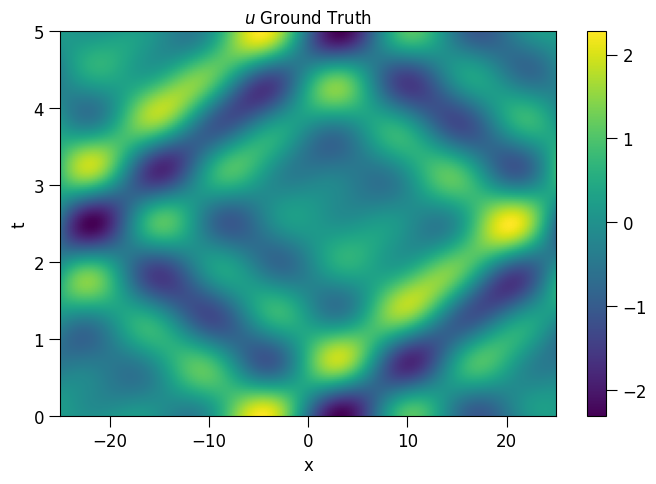

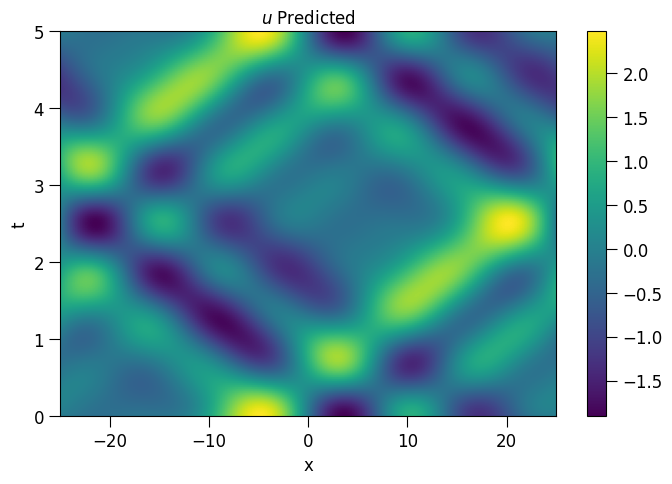

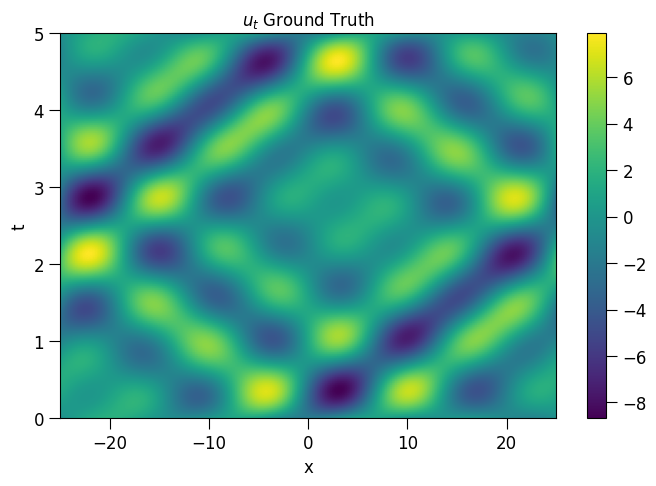

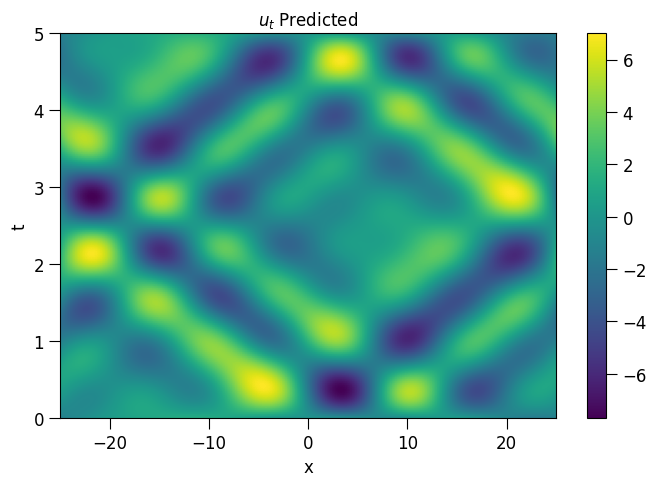

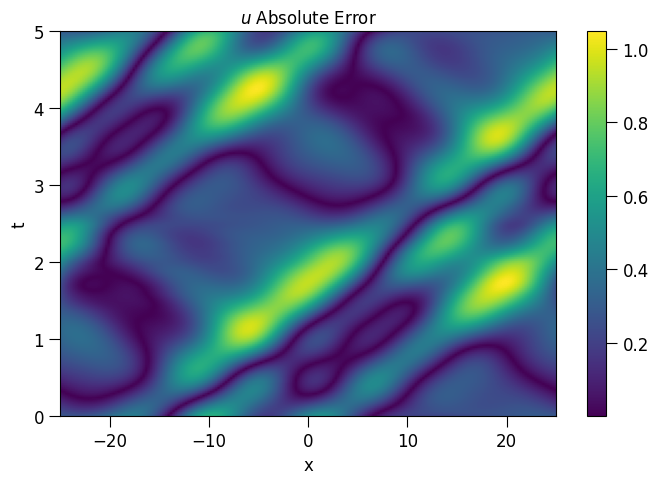

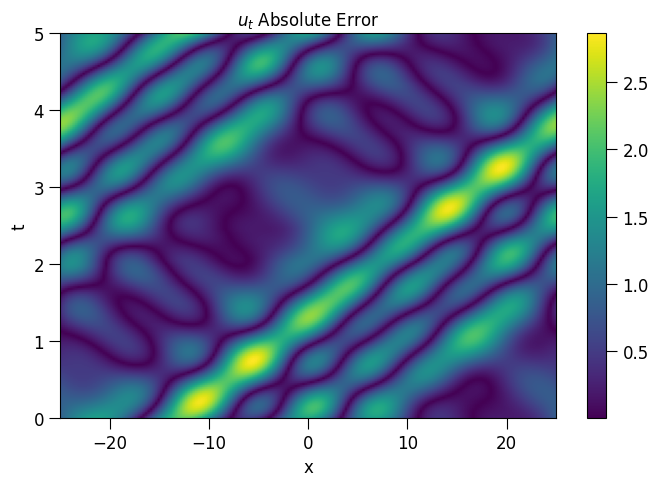

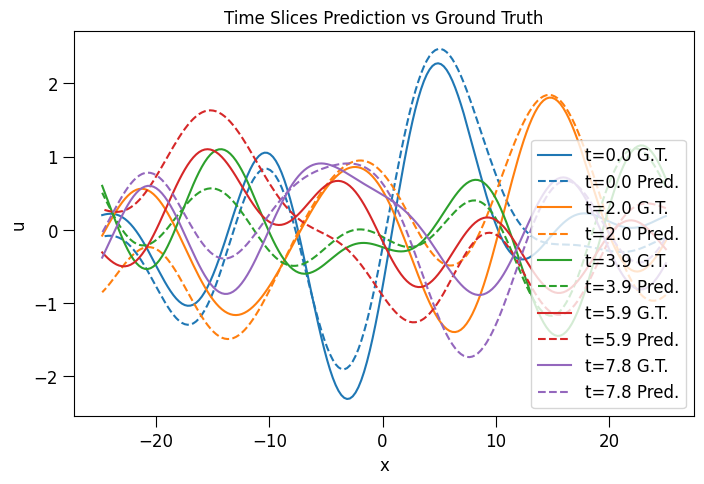

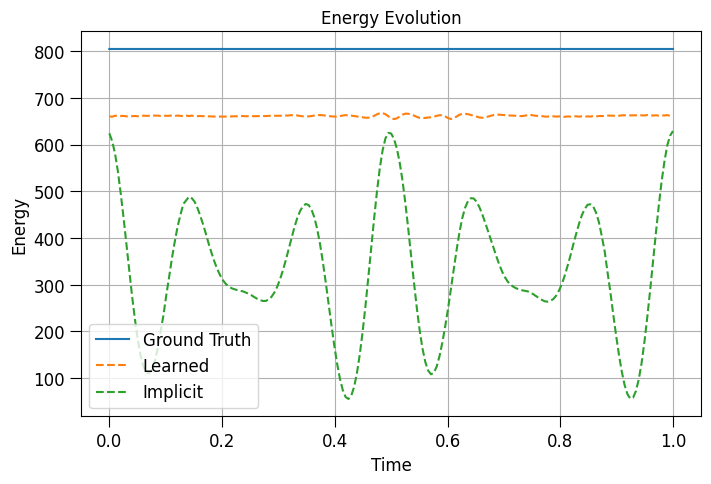

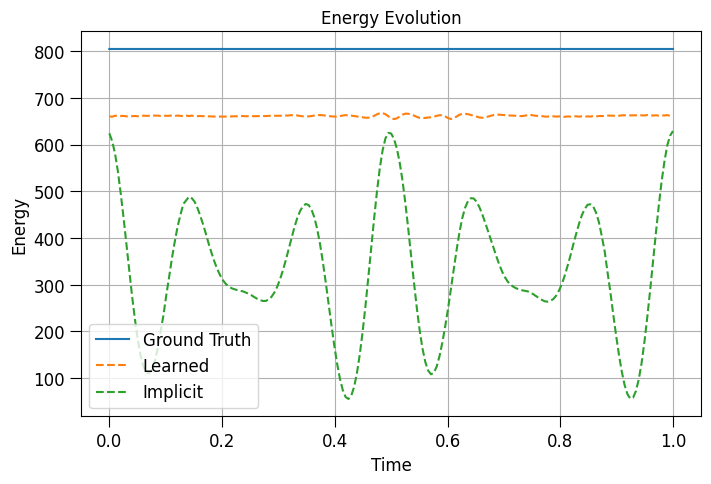

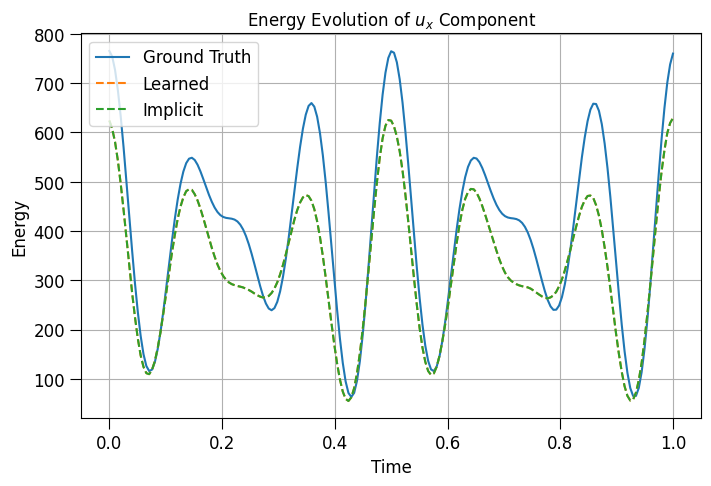

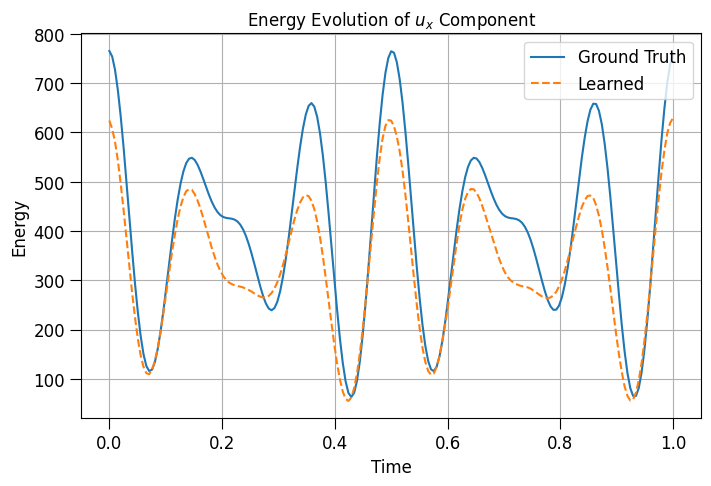

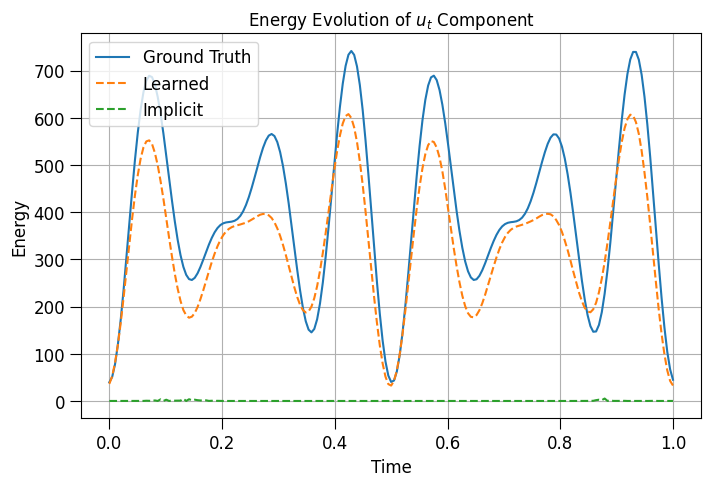

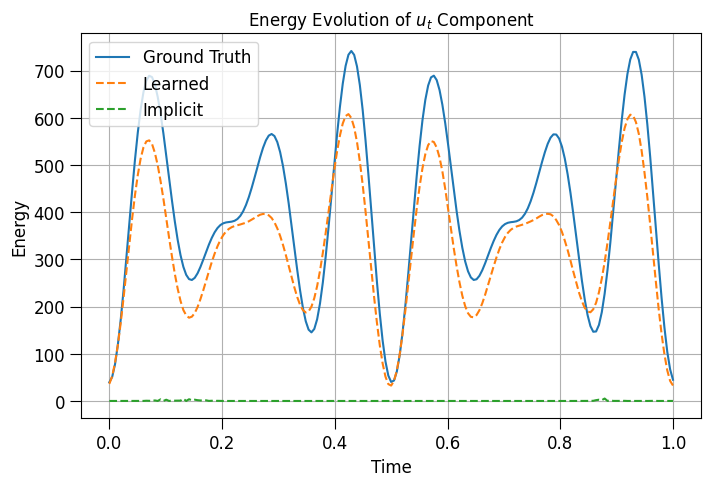

In [56]:


plot_1d_wave_evolution(data_path, save_dir, 0, exp_name, title=True, x_label=True, y_label=True)


**QR DOS**

In [86]:
data_path = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/dos_1_3/exp_n_20250419-060358/plots/data_0__test.pkl'
exp_name = 'qr_dos'
exp_label = 'QR DOS'
save_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave/{exp_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [87]:
exp_data = [(exp_label,['20250419-060358'])]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True, x_label=False)

In [88]:
loss_types = {'current_energy_loss_val':'Vanilla DeepONet Energy - implicit energy MSE'}

wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True)

In [89]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_dir)

 Label        training MSE       validation MSE        implicit energy MSE  learned energy MSE             test MSE   implicit energy MSE test learned energy MSE test
QR DOS 0.010073 ± 0.000000 47.231444 ± 0.000000 12313051.234375 ± 0.000000 0.000003 ± 0.000000 43.334768 ± 0.000000 10847540.642578 ± 0.000000     0.000003 ± 0.000000


torch.Size([199, 1])
torch.Size([199, 1])


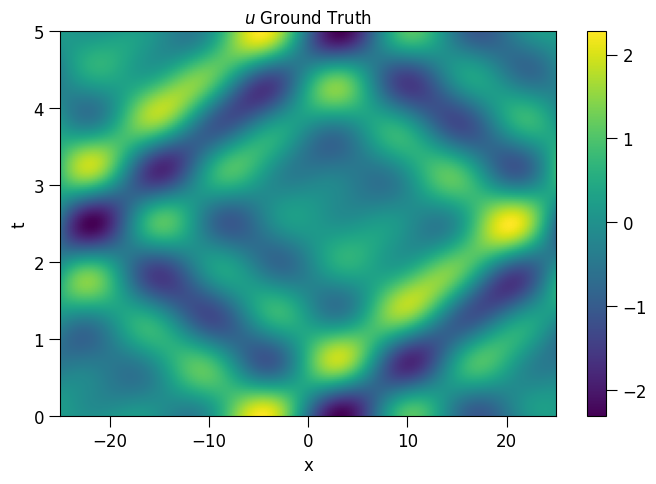

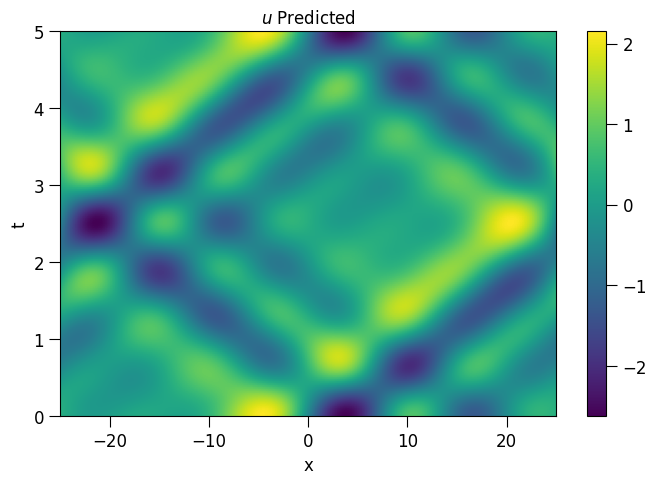

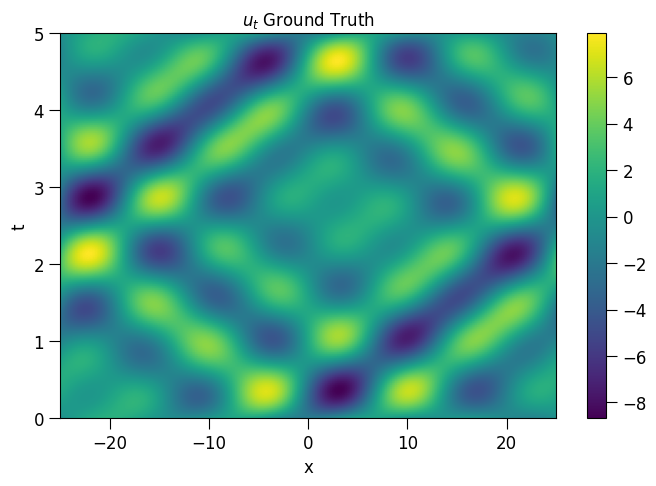

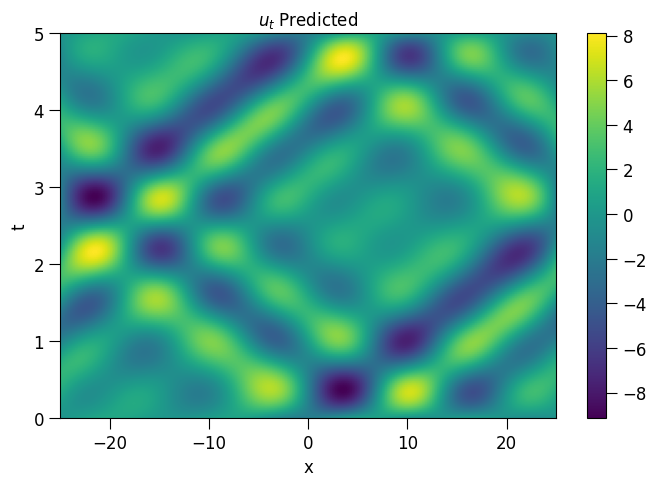

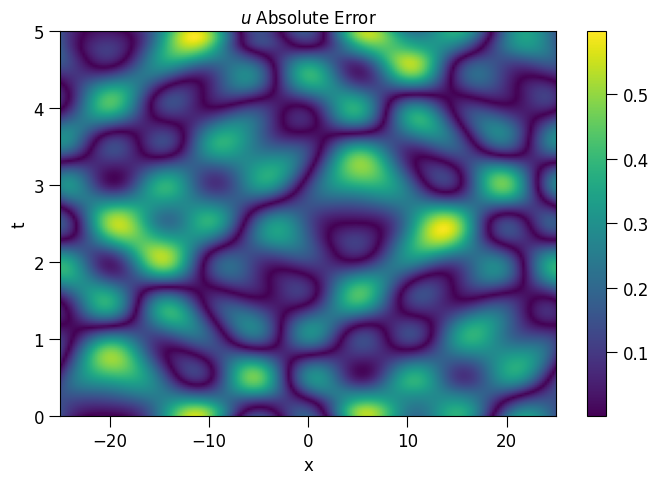

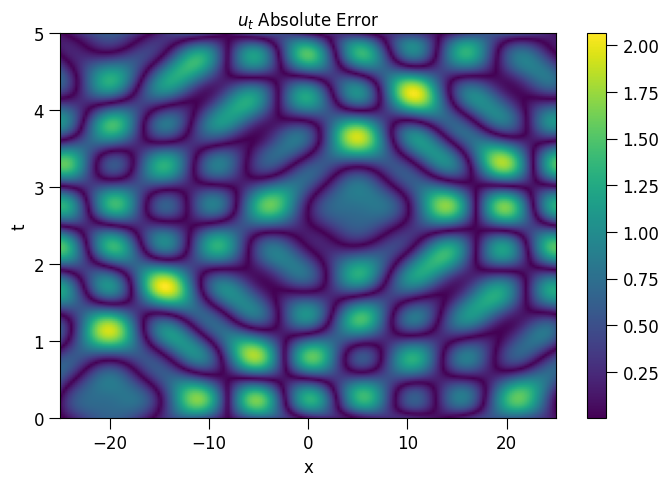

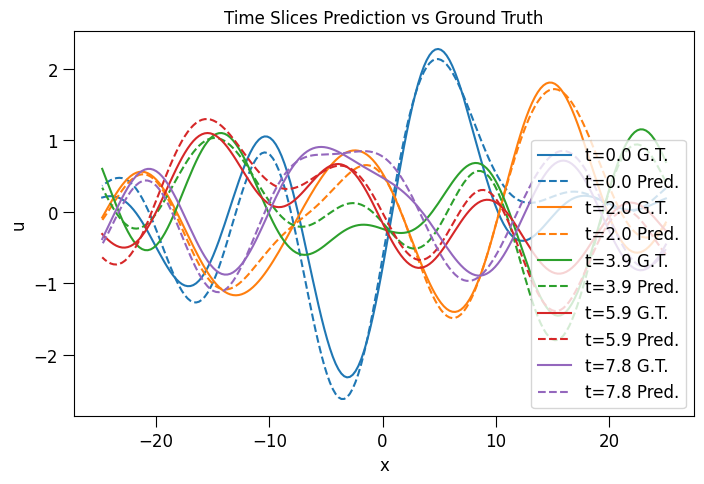

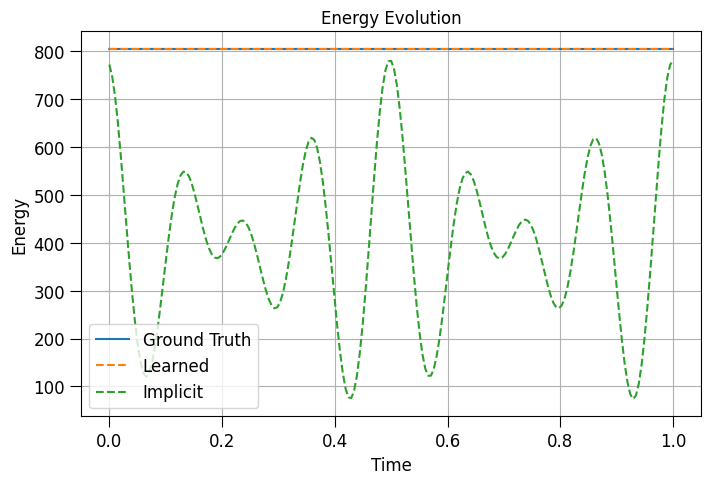

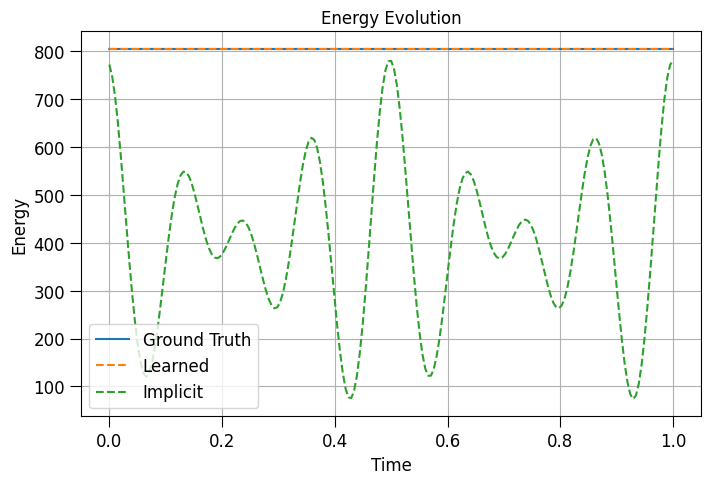

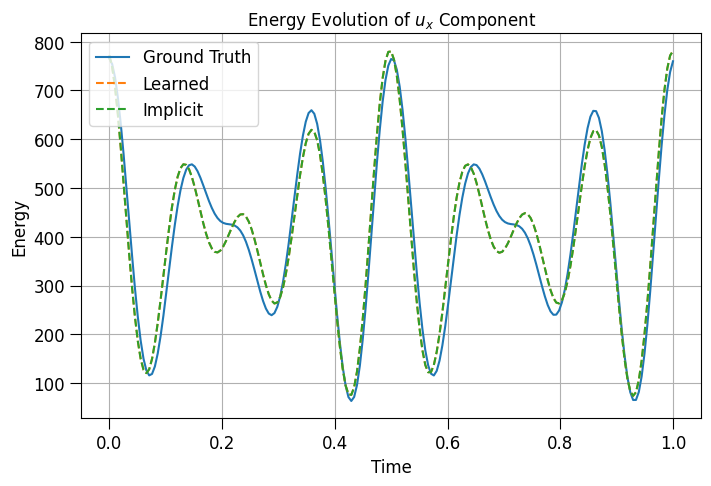

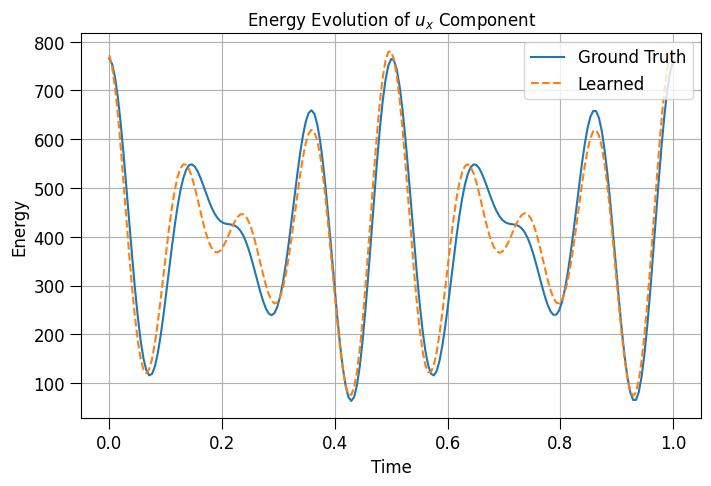

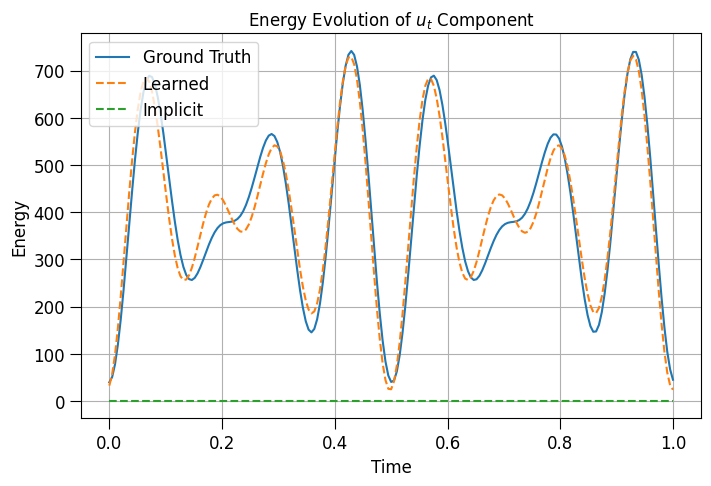

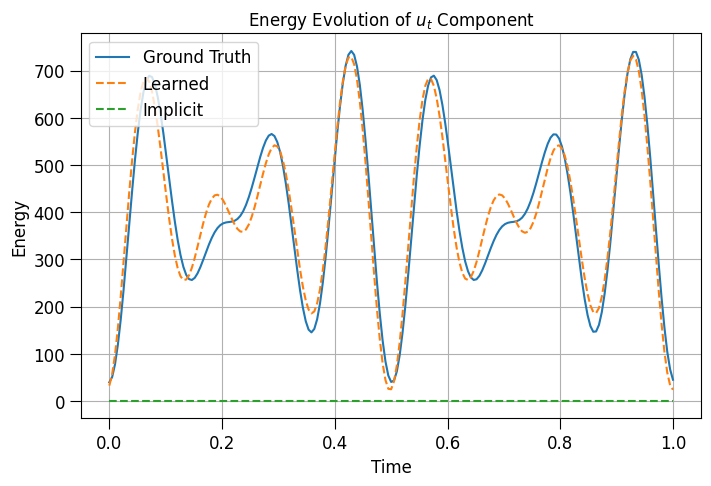

In [90]:


plot_1d_wave_evolution(data_path, save_dir, 0, exp_name, title=True, x_label=True, y_label=True)


**Norm DOS**

In [65]:
data_path = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/dos_1_2/exp_n_20250419-030258/plots/data_0__test.pkl'
exp_name = 'norm_dos'
exp_label = 'Normalized DOS'
save_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave/{exp_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [66]:
exp_data = [(exp_label,['20250419-030258'])]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True, x_label=False)

In [67]:
loss_types = {'current_energy_loss_val':'Vanilla DeepONet Energy - implicit energy MSE'}

wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True)

In [71]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_dir)

         Label        training MSE       validation MSE        implicit energy MSE  learned energy MSE             test MSE   implicit energy MSE test learned energy MSE test
Normalized DOS 0.037985 ± 0.000000 42.136227 ± 0.000000 12248323.289062 ± 0.000000 0.000001 ± 0.000000 40.974960 ± 0.000000 10806888.697266 ± 0.000000     0.000001 ± 0.000000


torch.Size([199, 1])
torch.Size([199, 1])


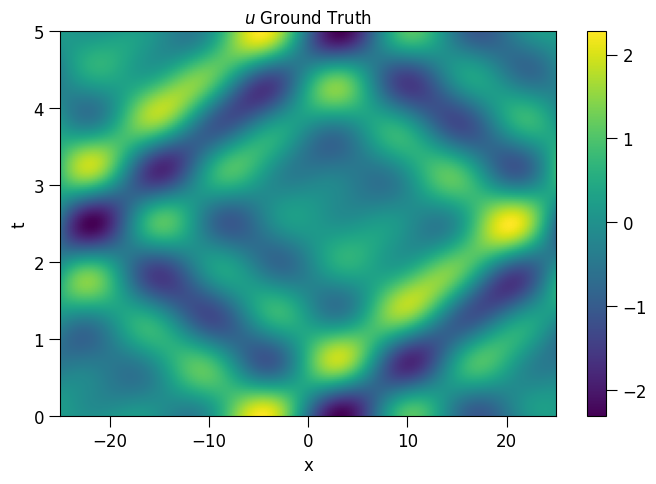

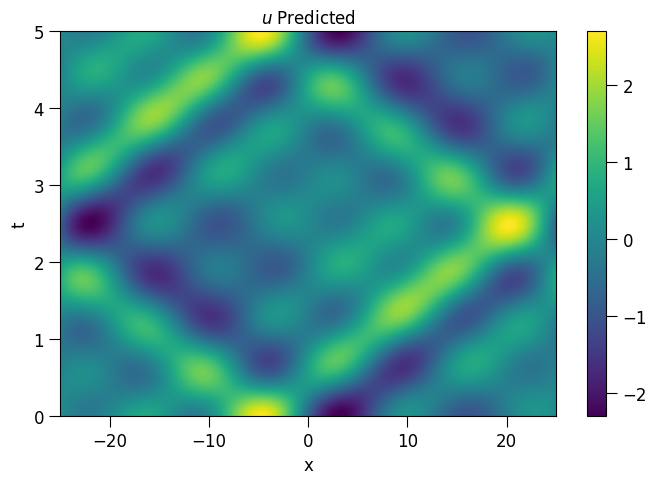

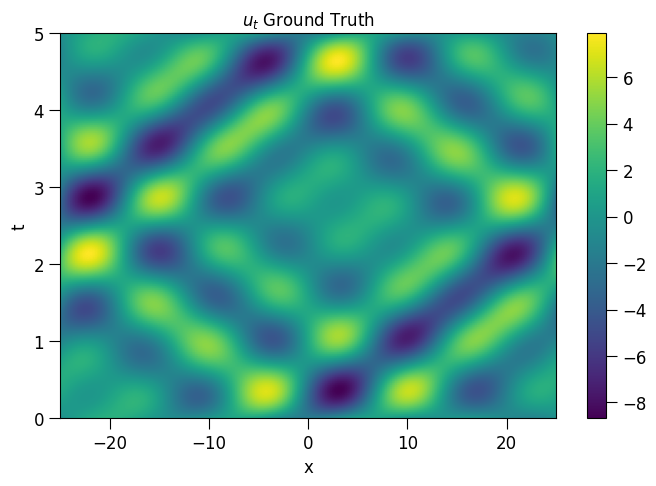

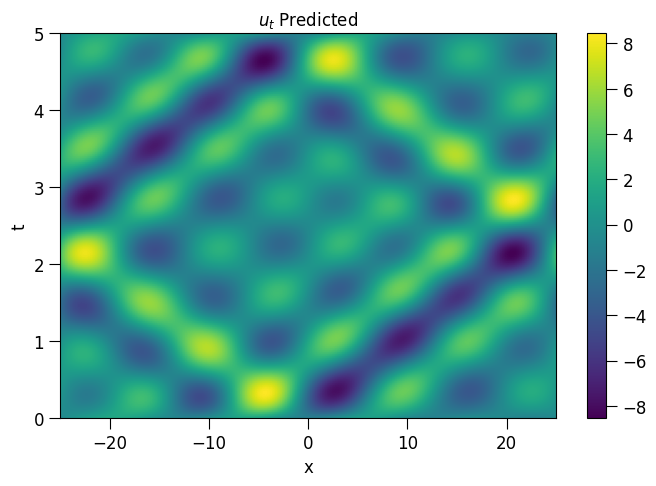

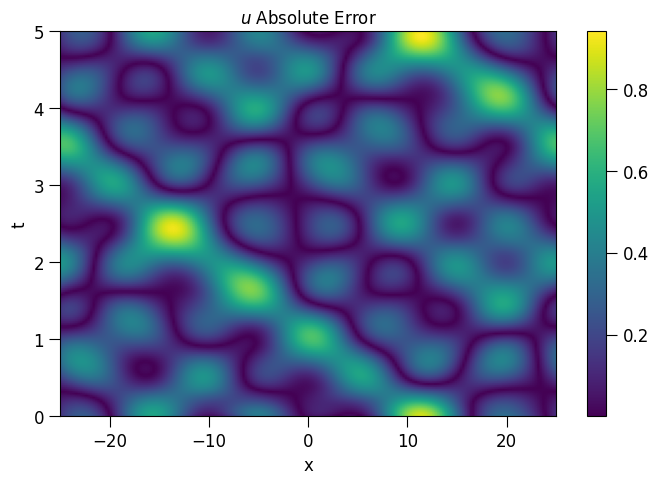

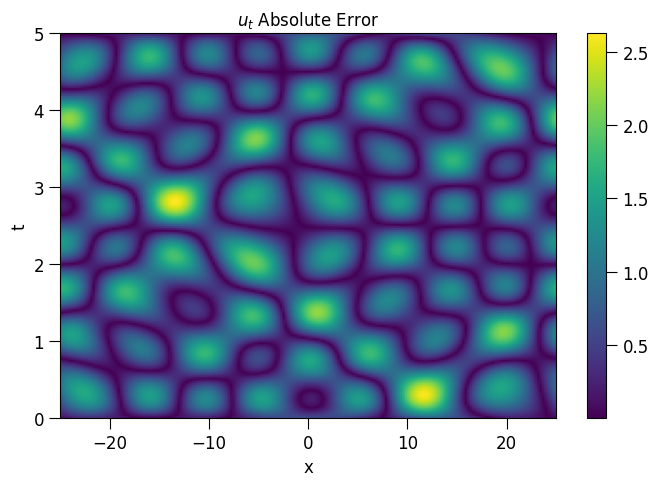

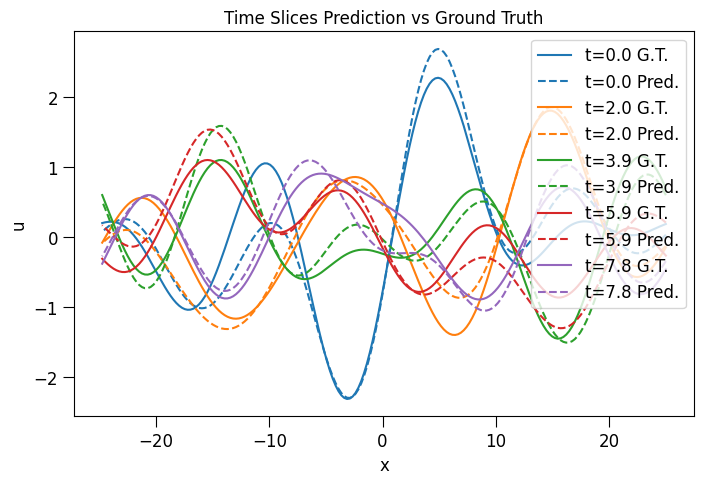

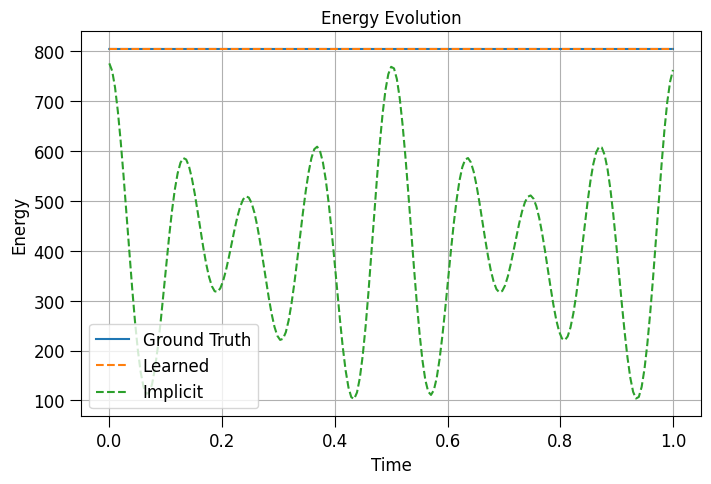

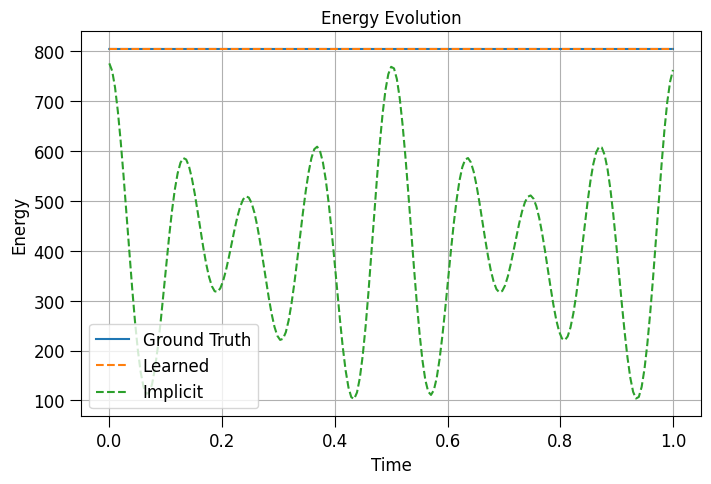

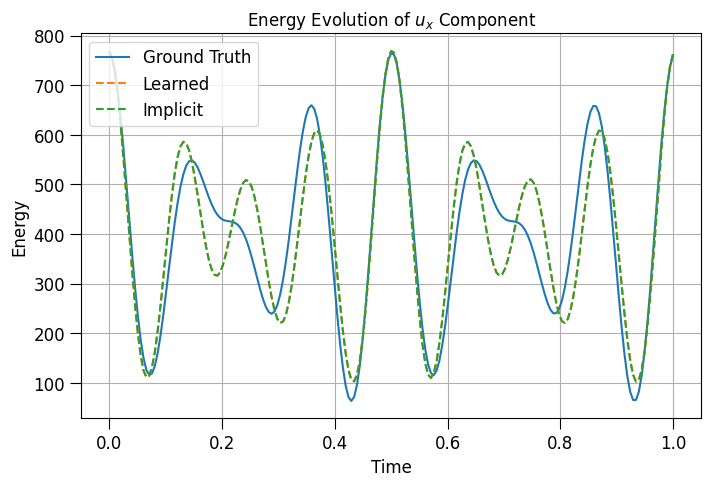

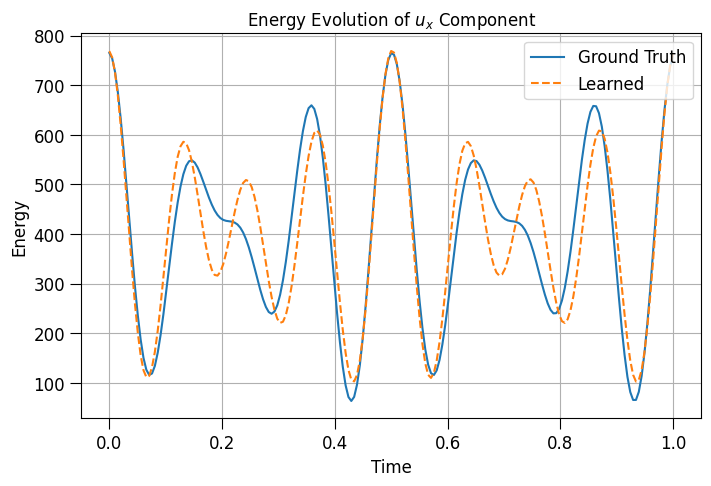

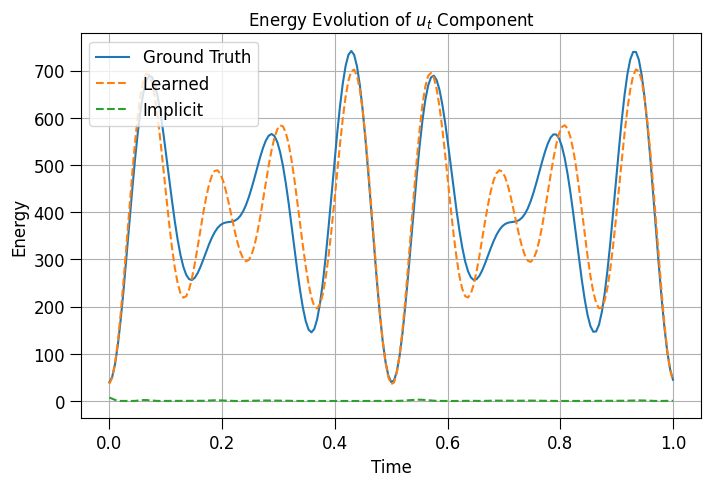

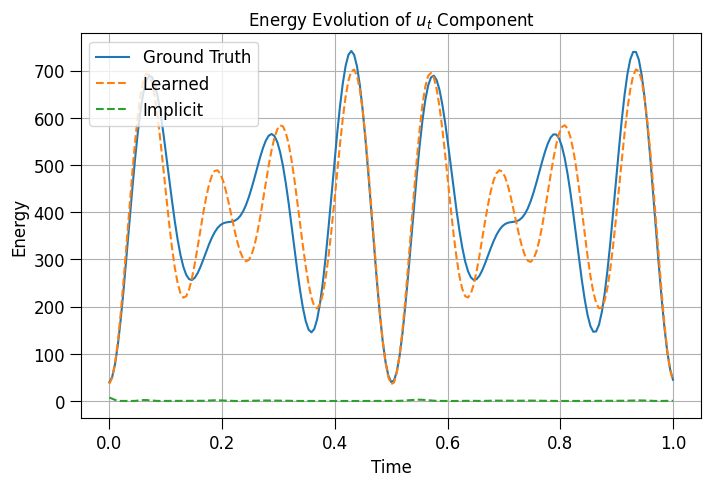

In [72]:


plot_1d_wave_evolution(data_path, save_dir, 0, exp_name, title=True, x_label=True, y_label=True)


**Implicit Norm DOS**

still to be run...

**Vanilla AFNO**

In [79]:
data_path = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/full_fourier/experiments/afno_1_1/exp_n_20250418-175723/plots/data_0__test.pkl'
exp_name = 'vanilla_afno'
exp_label = 'Vanilla AFNO'
save_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave/{exp_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [74]:
exp_data = [(exp_label,['20250418-175723'])]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True, x_label=False)

In [75]:
loss_types = {'current_energy_loss_val':'Vanilla DeepONet Energy - implicit energy MSE'}

wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True)

In [76]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_dir)

Skipping run 20250418-175723 due to error: 'learned_energy_loss_val'
Skipping run 20250418-175723 due to error: 'learned_energy_loss_test'
       Label        training MSE      validation MSE     implicit energy MSE learned energy MSE            test MSE implicit energy MSE test learned energy MSE test
Vanilla AFNO 0.000627 ± 0.000000 0.000756 ± 0.000000 72738.960938 ± 0.000000                N/A 0.000688 ± 0.000000  60575.960938 ± 0.000000                     N/A


/var/folders/9z/g5qd8cf95dg743cjhmdb6zsw0000gn/T/ipykernel_44364/3934173539.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data.get('x')) if data.get('x') is not None else None


torch.Size([199])
torch.Size([199])


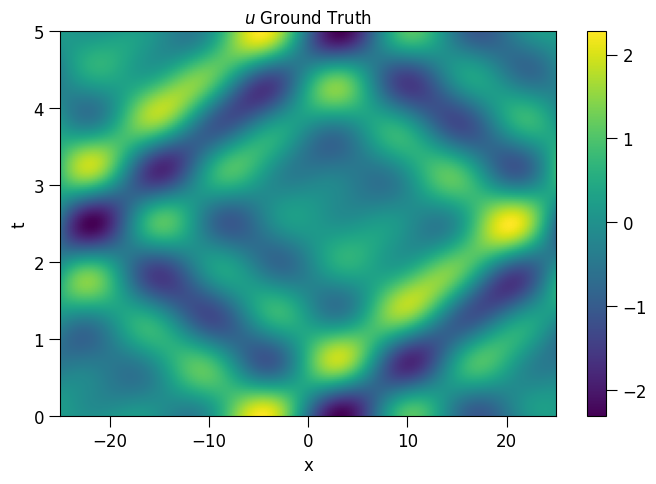

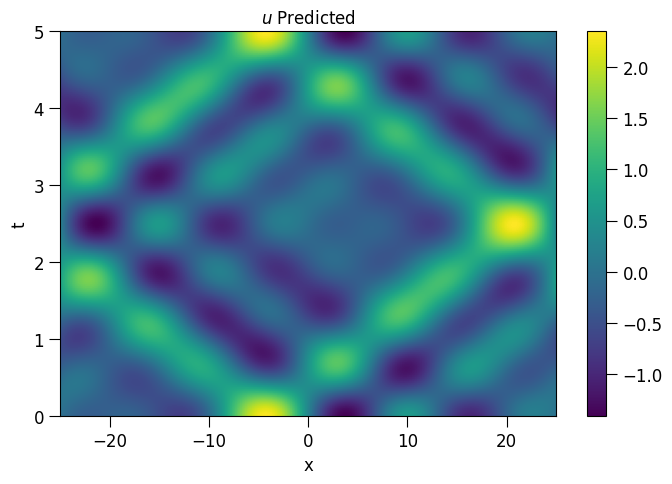

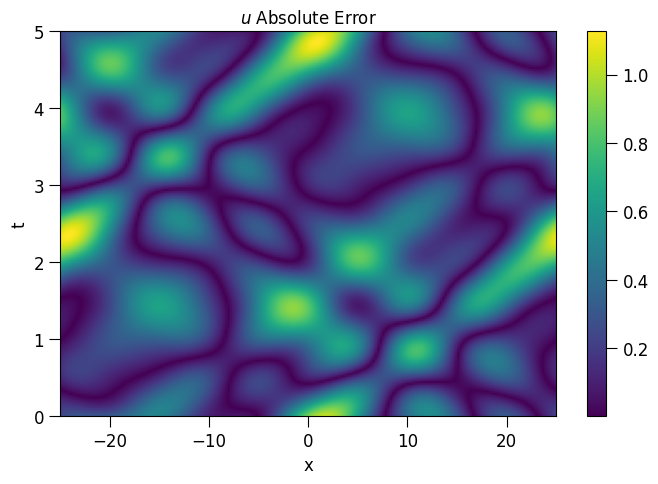

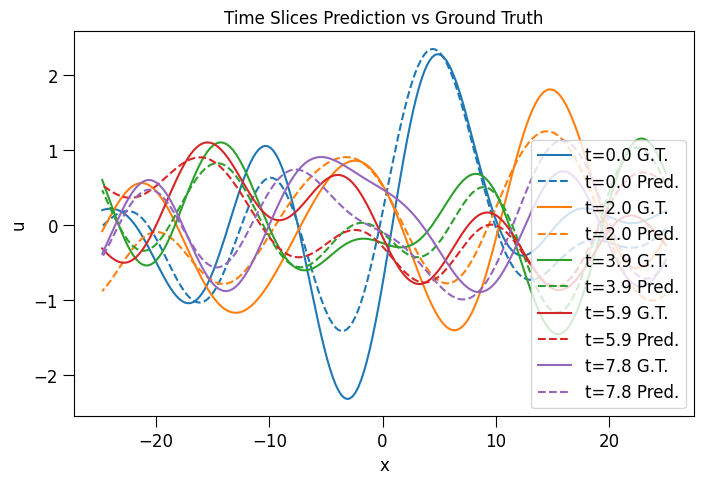

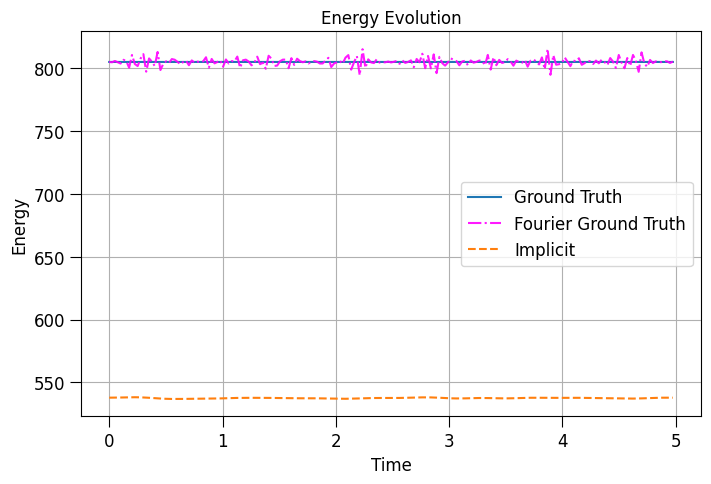

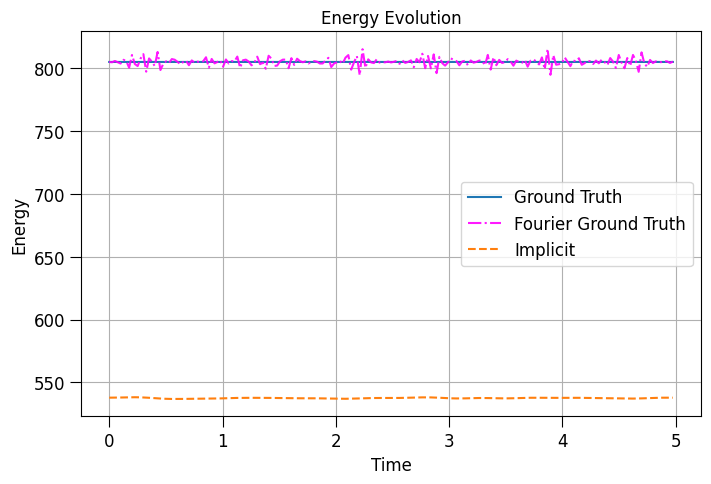

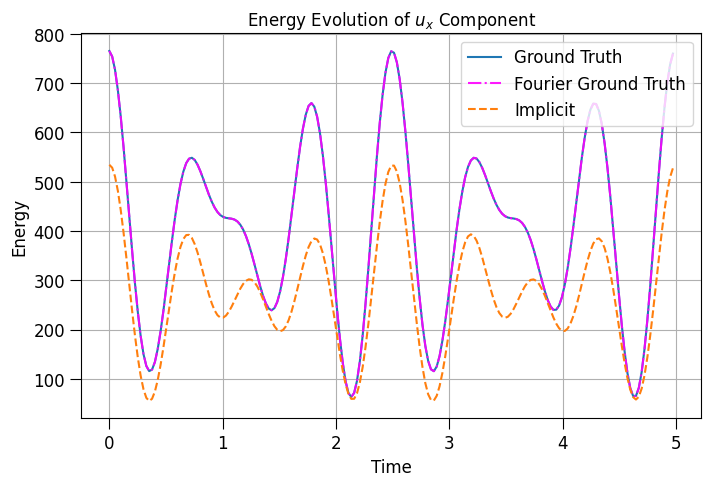

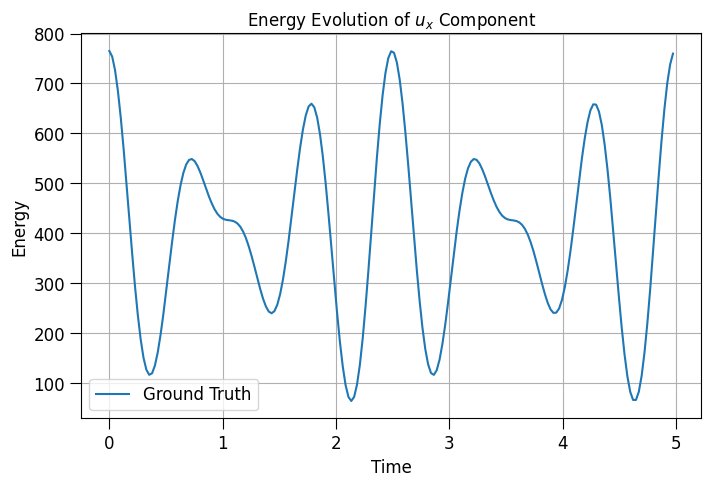

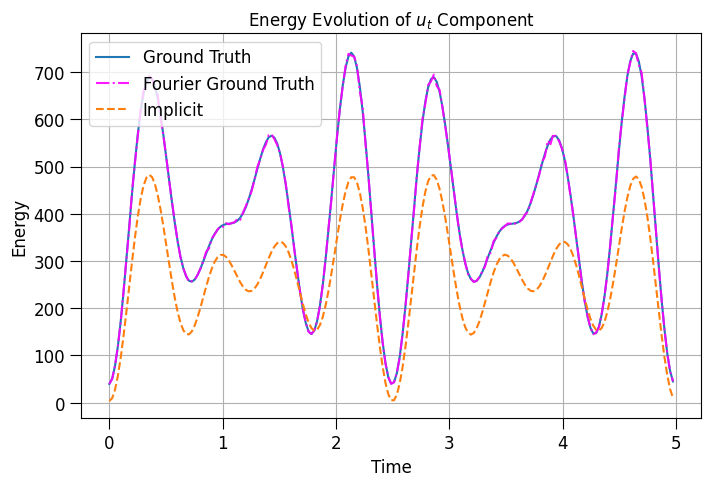

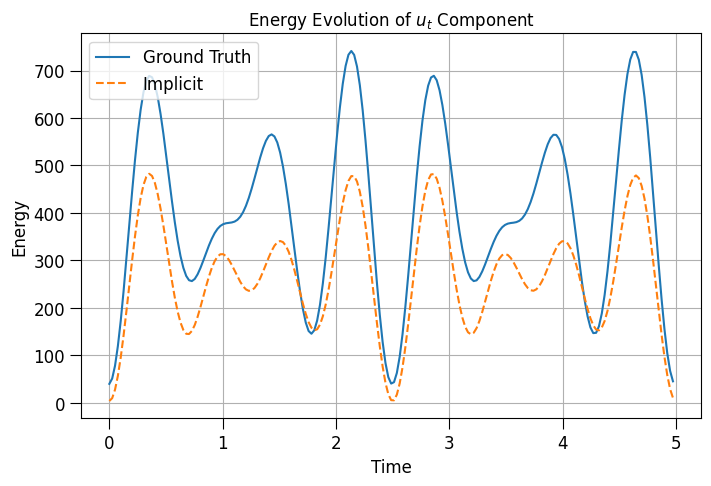

In [80]:

plot_1d_wave_evolution(data_path, save_dir, 0, exp_name, title=True, x_label=True, y_label=True)


**Norm AFNO**

In [81]:
data_path = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/full_fourier/experiments/afno_1_2/exp_n_20250418-191509/plots/data_0__test.pkl'
exp_name = 'norm_afno'
exp_label = 'Normalized AFNO'
save_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots/wave/{exp_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [82]:
exp_data = [(exp_label,['20250418-191509'])]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, legend_font=16, title=exp_label, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True, x_label=False)

In [83]:
loss_types = {'current_energy_loss_val':'Vanilla DeepONet Energy - implicit energy MSE'}

wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_dir, make_legend=True)

In [84]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_dir)

Skipping run 20250418-191509 due to error: 'learned_energy_loss_val'
Skipping run 20250418-191509 due to error: 'learned_energy_loss_test'
          Label        training MSE      validation MSE implicit energy MSE learned energy MSE            test MSE implicit energy MSE test learned energy MSE test
Normalized AFNO 0.000000 ± 0.000000 0.000000 ± 0.000000 1.844963 ± 0.000000                N/A 0.000000 ± 0.000000      1.551465 ± 0.000000                     N/A


/var/folders/9z/g5qd8cf95dg743cjhmdb6zsw0000gn/T/ipykernel_44364/3934173539.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data.get('x')) if data.get('x') is not None else None


torch.Size([199])
torch.Size([199])


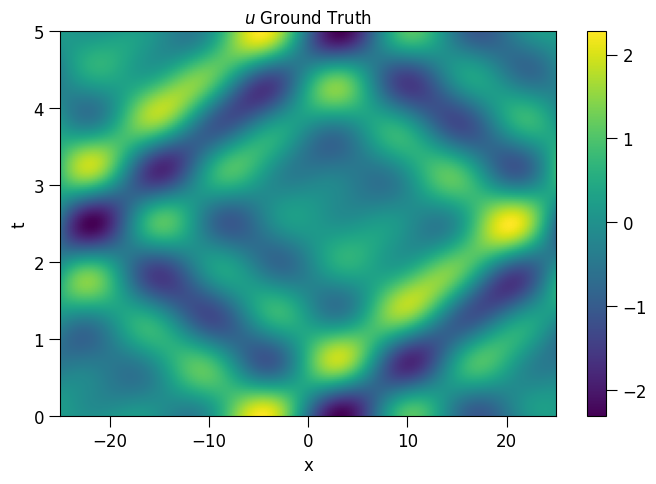

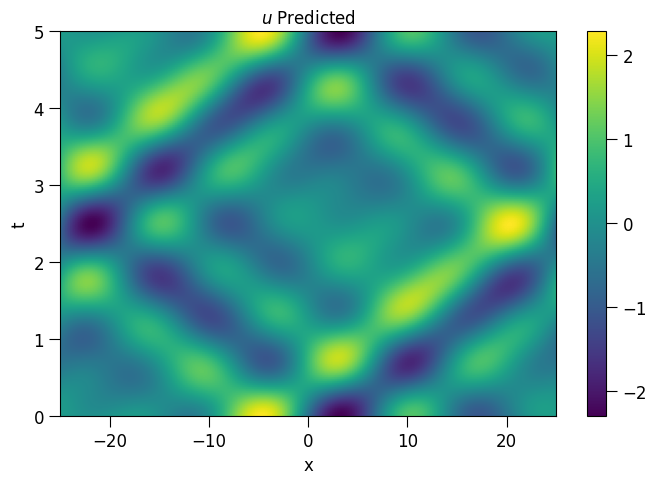

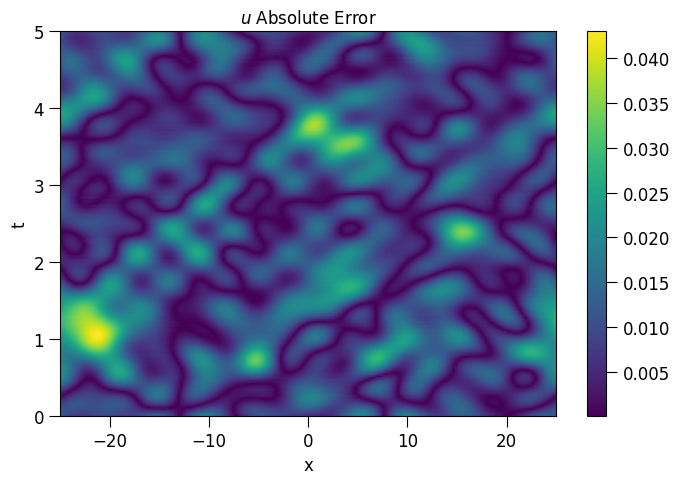

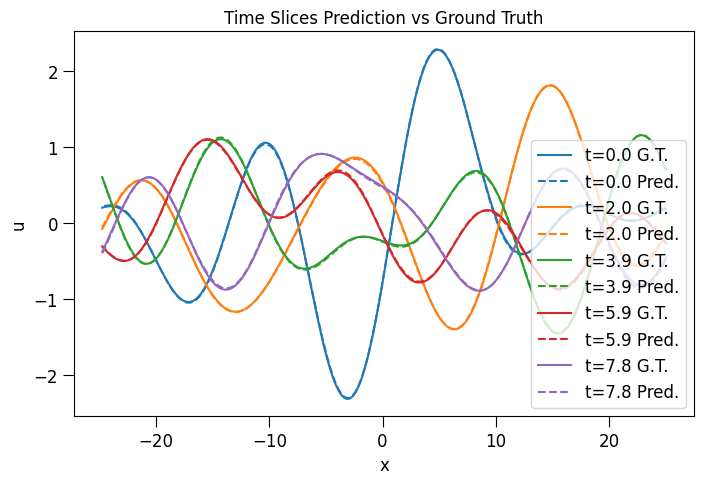

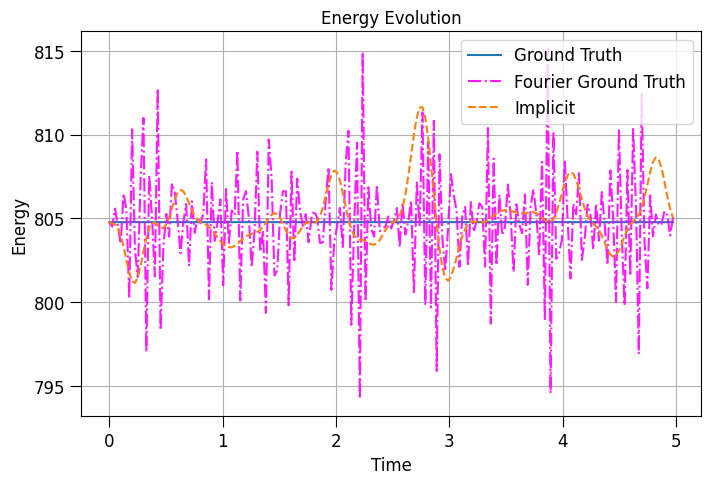

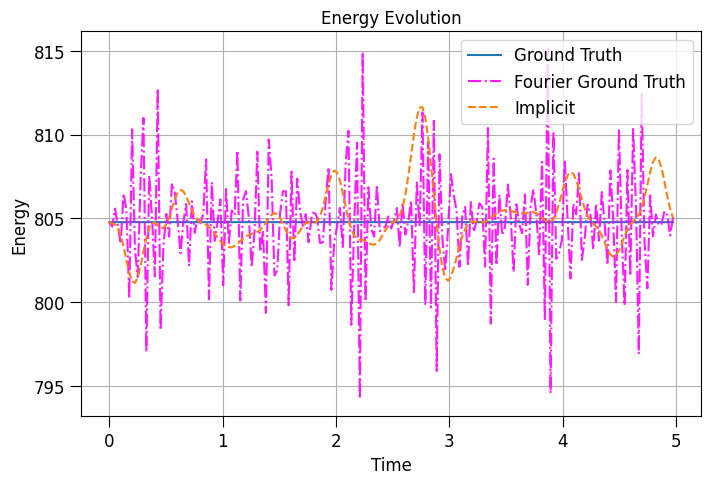

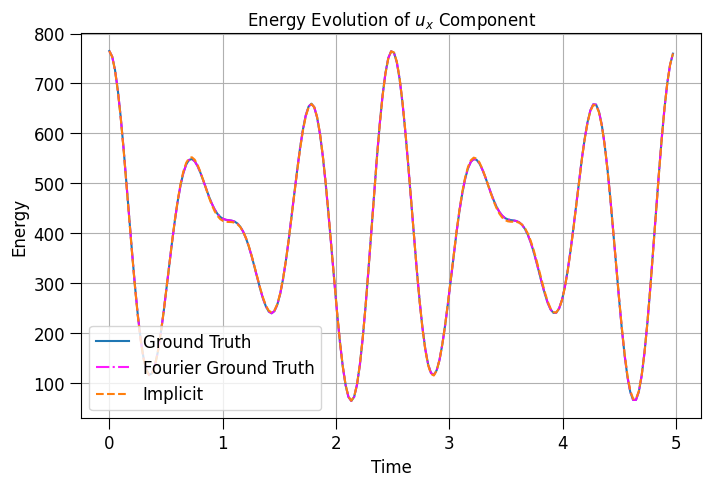

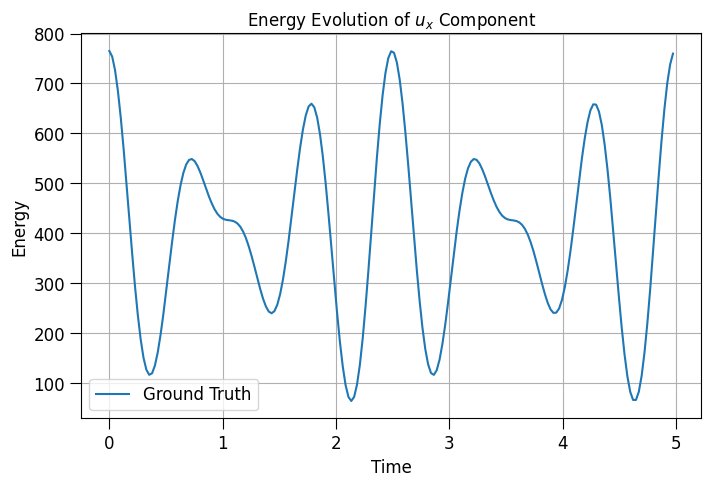

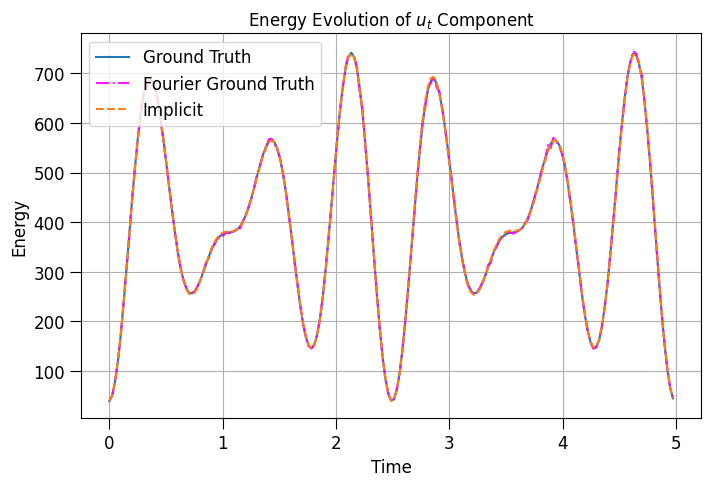

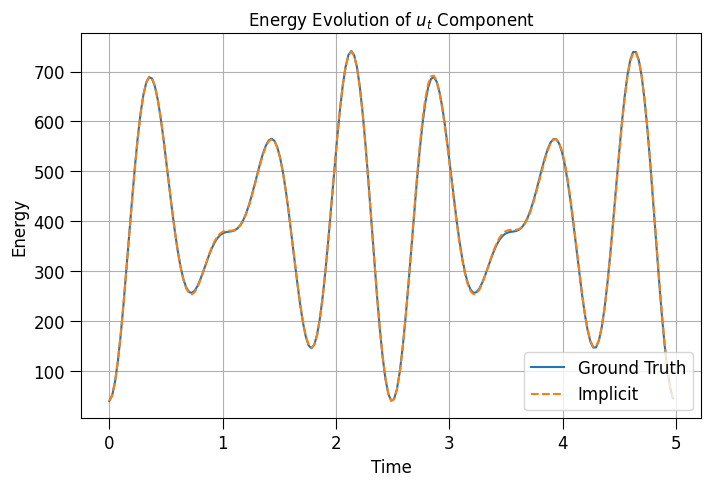

In [85]:


plot_1d_wave_evolution(data_path, save_dir, 0, exp_name, title=True, x_label=True, y_label=True)
